## Importing Required Libraries

In [ ]:
import gdown
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, Dropout, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
tf.random.set_seed(42)


2025-05-03 09:46:11.180522: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746265571.204457   71497 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746265571.211926   71497 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import permutation_importance

In [3]:
import shap
from tensorflow.keras.models import Model
import ipywidgets as widgets
from IPython.display import display
import pandas as pd

## Installing Required Packages

In [ ]:
!pip install --upgrade scikit-learn
!pip install --upgrade imbalanced-learn

## Download Data from Google Drive

In [4]:
# Example: Replace this with your real file link
drive_link = 'https://drive.google.com/file/d/1-1vVh7moyW_eBKl_GL-TDILl-LnqMYk0/view?usp=sharing'

file_id = drive_link.split('/d/')[1].split('/')[0]
gdown_url = f'https://drive.google.com/uc?id={file_id}'

output_file = 'sepsis_data.csv'
gdown.download(gdown_url, output_file, quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=1-1vVh7moyW_eBKl_GL-TDILl-LnqMYk0
From (redirected): https://drive.google.com/uc?id=1-1vVh7moyW_eBKl_GL-TDILl-LnqMYk0&confirm=t&uuid=09388f22-59c2-4efa-9086-518f6f366006
To: /kaggle/working/sepsis_data.csv
100%|██████████| 779M/779M [00:05<00:00, 149MB/s]  


'sepsis_data.csv'

## Load and Preprocess Data

In [5]:
def load_and_preprocess_data(filepath):
    """Load and clean data with memory-efficient datatypes"""
    print("\n[STEP 1] Loading data...")
    # Read column names first to set datatypes efficiently
    dtype_dict = {col: 'float32' for col in pd.read_csv(filepath, nrows=1).columns 
                if col not in ['Patient_ID', 'SepsisLabel', 'ICULOS']}
    dtype_dict.update({'Patient_ID': 'str', 'SepsisLabel': 'int8', 'ICULOS': 'int16'})
    
    # Use chunks for more memory-efficient loading of large files
    df = pd.read_csv(filepath, dtype=dtype_dict)
    df = df.sort_values(['Patient_ID', 'ICULOS'])
    
    # Handle missing values - simplified approach
    cols_to_impute = [col for col in df.columns if col not in ['Patient_ID', 'SepsisLabel', 'ICULOS']]
    
    # First forward fill within patient groups
    df[cols_to_impute] = df.groupby('Patient_ID')[cols_to_impute].transform(lambda x: x.ffill())
    
    # Then backward fill remaining values
    df[cols_to_impute] = df.groupby('Patient_ID')[cols_to_impute].transform(lambda x: x.bfill())
    
    # Finally fill any remaining NaNs with 0
    df[cols_to_impute] = df[cols_to_impute].fillna(0)
    
    print("Initial class distribution:")
    print(df['SepsisLabel'].value_counts())
    return df


## Create Patient Sequences

In [6]:
def create_patient_sequences(df, sequence_length=10):
    """Create sequences with memory-efficient implementation"""
    print(f"\n[STEP 2] Creating sequences (length={sequence_length})...")
    # Pre-allocate lists for efficiency
    sequences = []
    labels = []
    
    # Select only needed columns for feature extraction
    feature_cols = [col for col in df.columns if col not in ['Patient_ID', 'SepsisLabel', 'ICULOS']]
    
    # Process patients one by one to manage memory
    for pid, group in df.groupby('Patient_ID'):
        # Extract features and labels
        features = group[feature_cols].values
        sepsis_labels = group['SepsisLabel'].values
        
        # Handle sequences shorter than desired length
        if len(features) < sequence_length:
            # Pad with zeros at the beginning (representing historical data we don't have)
            pad_len = sequence_length - len(features)
            features = np.vstack([np.zeros((pad_len, features.shape[1])), features])
            sepsis_labels = np.concatenate([np.zeros(pad_len), sepsis_labels])
        
        # Create sliding windows - optimized to avoid unnecessary operations
        for i in range(0, len(features) - sequence_length + 1, 1):  # Step size of 1
            seq = features[i:i+sequence_length]
            # Label as 1 if sepsis occurs within the sequence window
            label = 1 if np.any(sepsis_labels[i:i+sequence_length] > 0) else 0
            sequences.append(seq)
            labels.append(label)
    
    # Convert to numpy arrays for TensorFlow compatibility
    X = np.array(sequences, dtype=np.float32)  # Explicit dtype
    y = np.array(labels, dtype=np.int8)  # Explicit dtype
    
    print(f"Created {len(X)} sequences")
    print(f"Class 0: {np.sum(y == 0)}, Class 1: {np.sum(y == 1)}")
    return X, y, feature_cols


## Undersampling Majority Class using Decision Tree

In [7]:
def decision_tree_undersampling(X, y, target_samples=35000):
    """Undersample majority class using decision tree predictions"""
    print(f"\nUndersampling majority class to {target_samples} samples...")
    
    # Get indices of majority class
    majority_indices = np.where(y == 0)[0]
    
    # If we already have fewer samples than target, return as is
    if len(majority_indices) <= target_samples:
        return X, y
    
    # Randomly select subset for efficiency
    np.random.shuffle(majority_indices)
    subset_indices = majority_indices[:min(50000, len(majority_indices))]  # Limit for efficiency
    
    # Flatten the time steps for feature importance calculation
    X_flattened = X[subset_indices].reshape(-1, X.shape[-1])
    y_flattened = np.repeat(y[subset_indices], X.shape[1])
    
    # Train decision tree to find most important samples
    dt = DecisionTreeClassifier(max_depth=5, random_state=42)
    dt.fit(X_flattened, y_flattened)
    
    # Get feature importances for each sample
    sample_importances = []
    for idx in subset_indices:
        # Calculate average feature importance across all time steps
        importance = np.mean([dt.feature_importances_ for _ in range(X.shape[1])], axis=0)
        sample_importances.append(np.sum(importance))
    
    # Select samples with highest importance scores
    selected_indices = np.argsort(sample_importances)[-target_samples:]
    
    # Combine with minority class
    minority_indices = np.where(y == 1)[0]
    final_indices = np.concatenate([subset_indices[selected_indices], minority_indices])
    
    return X[final_indices], y[final_indices]


##  Upsampling Minority Class using Decision Tree

In [8]:
def decision_tree_upsampling(X, y, target_samples=27000):
    """Upsample minority class using decision tree guided synthetic samples"""
    print(f"\nUpsampling minority class to {target_samples} samples...")
    
    # Get indices of minority class
    minority_indices = np.where(y == 1)[0]
    
    # If we already have more samples than target, return as is
    if len(minority_indices) >= target_samples:
        return X, y
    
    # Calculate how many samples we need to generate
    num_to_generate = target_samples - len(minority_indices)
    
    # Flatten the time steps for feature importance calculation
    X_flattened = X.reshape(-1, X.shape[-1])
    y_flattened = np.repeat(y, X.shape[1])
    
    # Train decision tree to understand feature relationships
    dt = DecisionTreeClassifier(max_depth=5, random_state=42)
    dt.fit(X_flattened, y_flattened)
    
    # Generate synthetic samples based on feature distributions
    synthetic_samples = []
    for _ in range(num_to_generate):
        # Randomly select a minority sample to base new sample on
        base_sample = X[np.random.choice(minority_indices)]
        
        # Create synthetic sample by perturbing features based on importance
        synthetic_sample = base_sample.copy()
        for t in range(X.shape[1]):  # For each time step
            for f in range(X.shape[2]):  # For each feature
                if dt.feature_importances_[f] > 0.01:  # Only modify important features
                    # Add noise proportional to feature importance
                    noise = np.random.normal(0, dt.feature_importances_[f] * 0.1)
                    synthetic_sample[t, f] += noise
        
        synthetic_samples.append(synthetic_sample)
    
    # Convert list of synthetic samples to numpy array with same shape as X
    synthetic_samples = np.array(synthetic_samples)
    
    # Combine real and synthetic samples
    X_upsampled = np.concatenate([X, synthetic_samples])
    y_upsampled = np.concatenate([y, np.ones(num_to_generate, dtype=np.int8)])
    
    return X_upsampled, y_upsampled


## Prepare Balanced Dataset

In [9]:
def prepare_balanced_dataset(X, y, target_class0=35000, target_class1=27000):
    """Prepare a balanced dataset with exact specified class counts"""
    print("\n[STEP 3] Preparing balanced dataset...")
    
    # First, undersample class 0 to exact target
    X_undersampled, y_undersampled = decision_tree_undersampling(X, y, target_samples=target_class0)
    
    # Then, upsample class 1 to exact target
    X_balanced, y_balanced = decision_tree_upsampling(X_undersampled, y_undersampled, target_samples=target_class1)
    
    # Shuffle the dataset
    indices = np.arange(len(y_balanced))
    np.random.shuffle(indices)
    X_balanced = X_balanced[indices]
    y_balanced = y_balanced[indices]
    
    print(f"Final balanced dataset - Class 0: {np.sum(y_balanced == 0)}, Class 1: {np.sum(y_balanced == 1)}")
    return X_balanced, y_balanced


## Train-Test Split

In [10]:
def custom_train_test_split_with_balancing(X, y, train_class0=35000, train_class1=27000):
    """Custom split with precise control over class distribution"""
    print("\n[STEP 4] Custom train-test split with balanced classes...")
    
    # Get indices for each class
    indices_class0 = np.where(y == 0)[0]
    indices_class1 = np.where(y == 1)[0]
    
    print(f"Total samples - Class 0: {len(indices_class0)}, Class 1: {len(indices_class1)}")
    
    # Make sure we don't request more samples than available
    train_class0 = min(train_class0, len(indices_class0))
    train_class1 = min(train_class1, len(indices_class1))
    
    # Randomly select indices for training set for each class
    np.random.shuffle(indices_class0)
    np.random.shuffle(indices_class1)
    
    train_indices_class0 = indices_class0[:train_class0]
    train_indices_class1 = indices_class1[:train_class1]
    
    # Remaining indices go to test set
    test_indices_class0 = indices_class0[train_class0:]
    test_indices_class1 = indices_class1[train_class1:]
    
    # Combine indices
    train_indices = np.concatenate([train_indices_class0, train_indices_class1])
    test_indices = np.concatenate([test_indices_class0, test_indices_class1])
    
    # Shuffle the training indices
    np.random.shuffle(train_indices)
    
    # Create the training and test sets
    X_train = X[train_indices]
    y_train = y[train_indices]
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    print(f"Training set - Class 0: {np.sum(y_train == 0)}, Class 1: {np.sum(y_train == 1)}")
    print(f"Test set - Class 0: {np.sum(y_test == 0)}, Class 1: {np.sum(y_test == 1)}")
    
    return X_train, X_test, y_train, y_test


## Model Evaluation

In [12]:
# Evaluation function
def evaluate_model(model, X, y, set_name="Test"):
    """Evaluate model performance"""
    print(f"\n{set_name} Set Evaluation:")
    
    y_prob = model.predict(X)
    y_pred = (y_prob > 0.5).astype(int)
    
    print(classification_report(y, y_pred))
    
    auc = roc_auc_score(y, y_prob)
    print(f"ROC AUC: {auc:.4f}")
    
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=['No Sepsis', 'Sepsis'],
               yticklabels=['No Sepsis', 'Sepsis'])
    plt.title(f'Confusion Matrix - {set_name} Set')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


## Main Execution - Load Data and Preprocess

In [14]:
filepath = "/kaggle/working/sepsis_data.csv"
df = load_and_preprocess_data(filepath)
X, y, feature_cols = create_patient_sequences(df, sequence_length=10)


[STEP 1] Loading data...
Initial class distribution:
SepsisLabel
0    1510640
1      26715
Name: count, dtype: int64

[STEP 2] Creating sequences (length=10)...
Created 1179170 sequences
Class 0: 1157517, Class 1: 21653


## Check and Drop Columns

In [15]:
# Check if columns exist before dropping
cols_to_drop = ['Unit2_observed', 'Unit1_observed', 'HospAdmTime']
existing_cols = [col for col in cols_to_drop if col in df.columns]

if existing_cols:
    df = df.drop(columns=existing_cols)
else:
    print("None of these columns exist in the DataFrame")


##  Balance Dataset

In [16]:

X_balanced, y_balanced = prepare_balanced_dataset(X, y, target_class0=50022, target_class1=35000)
X_train, X_test, y_train, y_test = custom_train_test_split_with_balancing(X_balanced, y_balanced, train_class0=35000, train_class1=27000)



[STEP 3] Preparing balanced dataset...

Undersampling majority class to 50022 samples...

Upsampling minority class to 35000 samples...
Final balanced dataset - Class 0: 50000, Class 1: 35000

[STEP 4] Custom train-test split with balanced classes...
Total samples - Class 0: 50000, Class 1: 35000
Training set - Class 0: 35000, Class 1: 27000
Test set - Class 0: 15000, Class 1: 8000


Prepare the Data

In [18]:
# Reshape X_train and X_test to match the input format for 1D CNN
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

## Build 1D Convolutional Neural Networks (CNNs) Model

In [31]:
# Define model architecture
model_cnn = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])),
    MaxPooling1D(pool_size=2),
    Conv1D(128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')  # Use 'softmax' for multi-class classification
])


## Train the Model

In [32]:
# Compile the model
model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', AUC()])

# Train the model
history_cnn = model_cnn.fit(X_train_reshaped, y_train, epochs=20, batch_size=64, validation_data=(X_test_reshaped, y_test))


Epoch 1/20
969/969 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6269 - auc_5: 0.6513 - loss: 0.7605 - val_accuracy: 0.7031 - val_auc_5: 0.7586 - val_loss: 0.5679
Epoch 2/20
969/969 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7089 - auc_5: 0.7735 - loss: 0.5656 - val_accuracy: 0.7307 - val_auc_5: 0.7864 - val_loss: 0.5274
Epoch 3/20
969/969 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7251 - auc_5: 0.7978 - loss: 0.5395 - val_accuracy: 0.7293 - val_auc_5: 0.7914 - val_loss: 0.5271
Epoch 4/20
969/969 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7338 - auc_5: 0.8091 - loss: 0.5260 - val_accuracy: 0.7390 - val_auc_5: 0.8046 - val_loss: 0.5178
Epoch 5/20
969/969 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7396 - auc_5: 0.8185 - loss: 0.5151 - val_accuracy: 0.7392 - val_auc_5: 0.8039 - val_loss: 0.5222
Epoch 6/20
969/969 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7500 - auc_5: 0.8281 - loss: 0.5026 - val_accuracy: 0.7434 - val_auc_5: 0.8126 - val_loss: 0.5119
Epoch 7/20
969/9

## Plot Training Metrics


[STEP 8] Plotting training metrics...


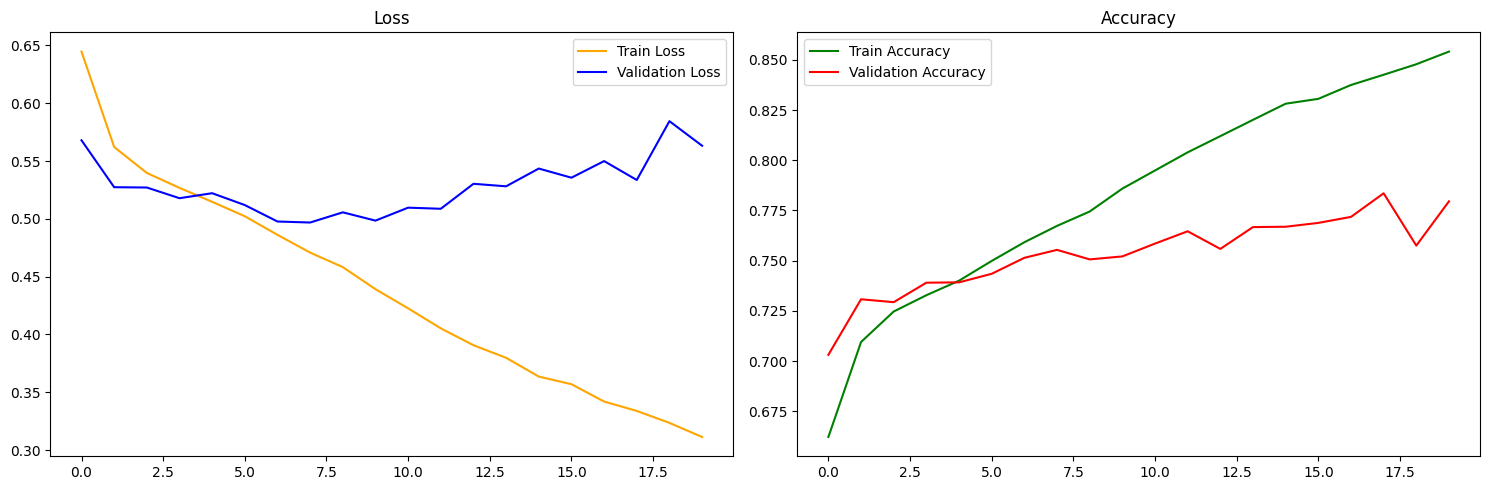

In [33]:

# Plot the training and validation metrics
print("\n[STEP 8] Plotting training metrics...")

# Plot Loss and AUC together in the first subplot
plt.figure(figsize=(15, 5))

# Plot Loss and AUC
plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['loss'], label='Train Loss', color='orange')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss', color='blue')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['accuracy'], label='Train Accuracy', color='green')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Confusion Matrix

## Evaluate Model

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


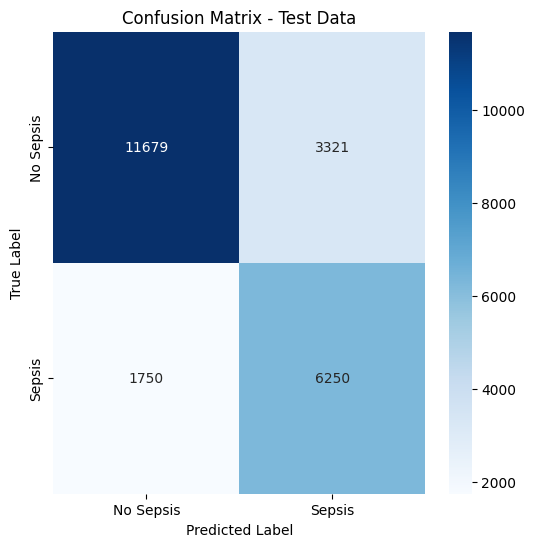


Classification Report for Test Data:
              precision    recall  f1-score   support

           0       0.87      0.78      0.82     15000
           1       0.65      0.78      0.71      8000

    accuracy                           0.78     23000
   macro avg       0.76      0.78      0.77     23000
weighted avg       0.79      0.78      0.78     23000



In [36]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate on test set
y_pred_test = (model_cnn.predict(X_test_reshaped) > 0.5).astype(int)  # Model is model_cnn
cm_test = confusion_matrix(y_test, y_pred_test)

# Plot Confusion Matrix for Test Data
plt.figure(figsize=(6, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=['No Sepsis', 'Sepsis'], yticklabels=['No Sepsis', 'Sepsis'])
plt.title('Confusion Matrix - Test Data')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Print Classification Report for Test Data
print("\nClassification Report for Test Data:")
print(classification_report(y_test, y_pred_test))


1938/1938 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


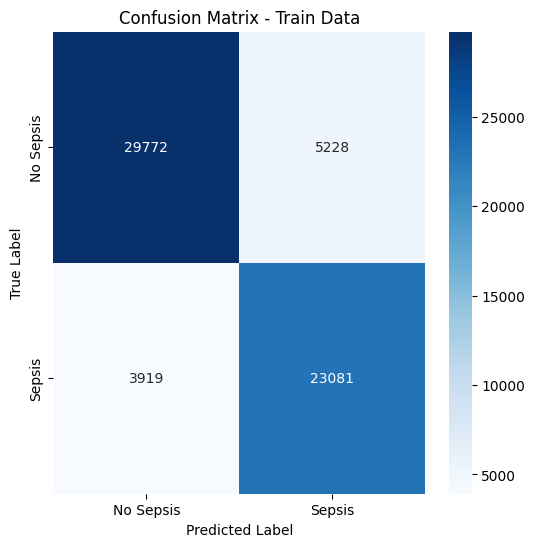


Classification Report for Train Data:
              precision    recall  f1-score   support

           0       0.88      0.85      0.87     35000
           1       0.82      0.85      0.83     27000

    accuracy                           0.85     62000
   macro avg       0.85      0.85      0.85     62000
weighted avg       0.85      0.85      0.85     62000



In [37]:
# Evaluate on train set
y_pred_train = (model_cnn.predict(X_train_reshaped) > 0.5).astype(int)  # Model is model_cnn
cm_train = confusion_matrix(y_train, y_pred_train)

# Plot Confusion Matrix for Train Data
plt.figure(figsize=(6, 6))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', xticklabels=['No Sepsis', 'Sepsis'], yticklabels=['No Sepsis', 'Sepsis'])
plt.title('Confusion Matrix - Train Data')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Print Classification Report for Train Data
print("\nClassification Report for Train Data:")
print(classification_report(y_train, y_pred_train))

## Surrogate Model (Decision Tree)

In [40]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

# Get model predictions (probabilities) from the CNN model
train_predictions = model_cnn.predict(X_train_reshaped)

# Convert probabilities to class labels (e.g., threshold of 0.5)
train_predictions_class = (train_predictions > 0.5).astype(int)

# Train a surrogate model (Decision Tree)
surrogate_model = DecisionTreeClassifier(max_depth=5)  # Limiting depth to prevent overfitting
surrogate_model.fit(X_train_reshaped.reshape(X_train_reshaped.shape[0], -1), train_predictions_class)

# Evaluate the surrogate model (on the training set for illustration)
y_train_predictions = surrogate_model.predict(X_train_reshaped.reshape(X_train_reshaped.shape[0], -1))

# Print classification report for the surrogate model's performance
print("Classification Report for Surrogate Model on Training Data:")
print(classification_report(train_predictions_class, y_train_predictions))


1938/1938 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Classification Report for Surrogate Model on Training Data:
              precision    recall  f1-score   support

           0       0.73      0.82      0.77     33691
           1       0.75      0.64      0.69     28309

    accuracy                           0.74     62000
   macro avg       0.74      0.73      0.73     62000
weighted avg       0.74      0.74      0.74     62000



## Time-Aware Feature Importance

1938/1938 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


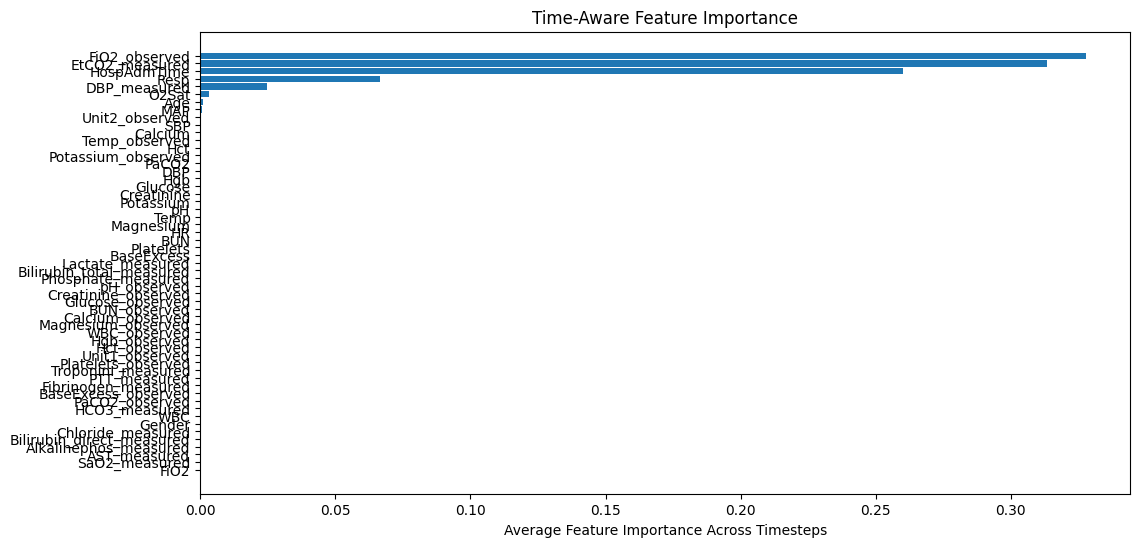

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier

# Get model predictions (probabilities)
train_predictions = model_cnn.predict(X_train_reshaped)  # CNN model
train_predictions_class = (train_predictions > 0.5).astype(int)

# Improved Approach 1: Average importance across timesteps
# ------------------------------------------------------
timestep_importances = []

for t in range(X_train_reshaped.shape[1]):  # For each timestep
    # Train on just this timestep's features
    surrogate = DecisionTreeClassifier(max_depth=5, random_state=42)
    surrogate.fit(X_train_reshaped[:, t, :], train_predictions_class)
    
    # Store feature importances for this timestep
    timestep_importances.append(surrogate.feature_importances_)

# Average importance across all timesteps
avg_feature_importance = np.mean(timestep_importances, axis=0)

# Plot feature importance
plt.figure(figsize=(12, 6))
sorted_idx = np.argsort(avg_feature_importance)
plt.barh(range(len(feature_cols)), avg_feature_importance[sorted_idx])
plt.yticks(range(len(feature_cols)), np.array(feature_cols)[sorted_idx])
plt.xlabel('Average Feature Importance Across Timesteps')
plt.title('Time-Aware Feature Importance')
plt.show()



##  Time-Aware Permutation Importance

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
3

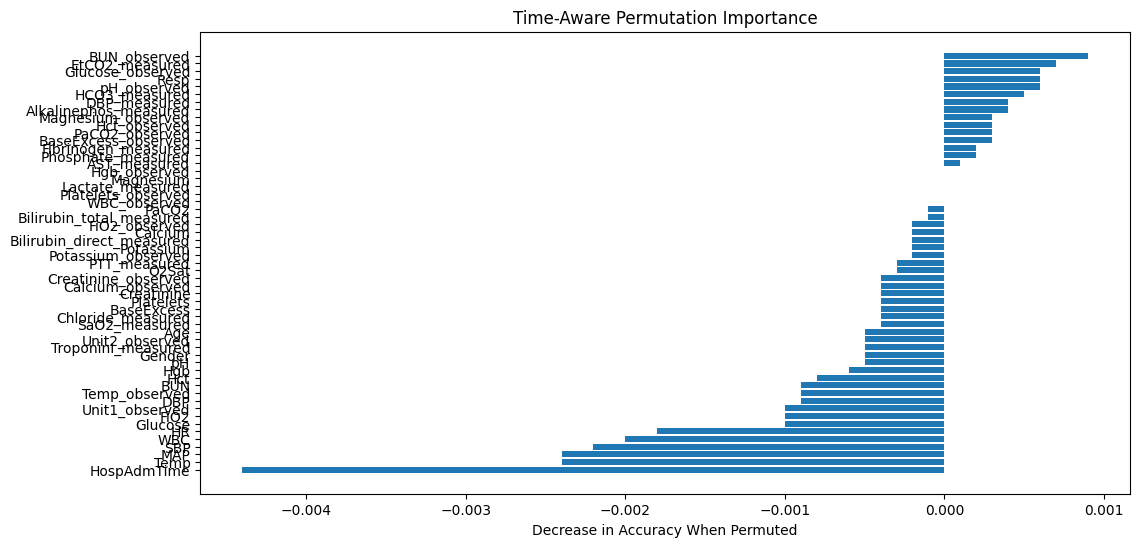

In [42]:
# Improved Approach 2: Permutation Importance
# ------------------------------------------
def time_aware_permutation_importance(model, X, y, feature_cols, n_repeats=5):
    baseline_score = np.mean(model.predict(X).round() == y)
    importance_scores = np.zeros(len(feature_cols))
    
    for i in range(len(feature_cols)):
        X_permuted = X.copy()
        # Permute feature across all timesteps
        X_permuted[:, :, i] = np.random.permutation(X_permuted[:, :, i])
        permuted_score = np.mean(model.predict(X_permuted).round() == y)
        importance_scores[i] = baseline_score - permuted_score
    
    return importance_scores

perm_importance = time_aware_permutation_importance(
    model_cnn, X_train_reshaped[:1000], y_train[:1000], feature_cols  # Use subset for speed
)

# Plot permutation importance
plt.figure(figsize=(12, 6))
sorted_idx = np.argsort(perm_importance)
plt.barh(range(len(feature_cols)), perm_importance[sorted_idx])
plt.yticks(range(len(feature_cols)), np.array(feature_cols)[sorted_idx])
plt.xlabel('Decrease in Accuracy When Permuted')
plt.title('Time-Aware Permutation Importance')
plt.show()

## Feature Importance Calculation

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import accuracy_score

# Set random seed for reproducibility
np.random.seed(42)

def get_top_features(model, X, y, feature_names, n_features=10):
    """Identify top important features using custom permutation importance for 3D data"""
    print("Calculating feature importances...")
    
    # Get baseline score
    baseline_score = accuracy_score(y, model.predict(X).round())
    
    feature_importances = np.zeros(X.shape[2])
    
    for feat_idx in tqdm(range(X.shape[2])):  # Loop through features
        X_permuted = X.copy()
        # Permute the feature across all timesteps
        for t in range(X.shape[1]):
            X_permuted[:, t, feat_idx] = np.random.permutation(X_permuted[:, t, feat_idx])
        
        # Get score with permuted feature
        permuted_score = accuracy_score(y, model.predict(X_permuted).round())
        feature_importances[feat_idx] = baseline_score - permuted_score
    
    # Get top features
    sorted_idx = np.argsort(feature_importances)[::-1]
    top_indices = sorted_idx[:n_features]
    top_features = [(feature_names[i], feature_importances[i]) 
                   for i in top_indices]
    
    print("\nTop 10 Important Features:")
    for i, (feat, imp) in enumerate(top_features, 1):
        print(f"{i}. {feat}: {imp:.4f}")
    
    return top_indices, feature_importances

##  Execute Feature Importance Calculation

In [44]:
# Execute feature importance calculation
print("Starting feature importance calculation...")
top_indices, feature_importances = get_top_features(
    model=model_cnn,  # Use the CNN model here
    X=X_test_reshaped,  # Ensure X_test_reshaped is 3D
    y=y_test,
    feature_names=feature_cols,  # List of feature names
    n_features=10
)


Starting feature importance calculation...
Calculating feature importances...
719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


  0%|          | 0/55 [00:00<?, ?it/s]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


  2%|▏         | 1/55 [00:01<01:02,  1.17s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


  4%|▎         | 2/55 [00:02<01:02,  1.17s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


  5%|▌         | 3/55 [00:03<01:00,  1.17s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


  7%|▋         | 4/55 [00:04<01:00,  1.19s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


  9%|▉         | 5/55 [00:05<00:58,  1.18s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 11%|█         | 6/55 [00:07<00:57,  1.18s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 13%|█▎        | 7/55 [00:08<00:55,  1.17s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 15%|█▍        | 8/55 [00:09<00:54,  1.16s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 16%|█▋        | 9/55 [00:10<00:53,  1.16s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 18%|█▊        | 10/55 [00:11<00:52,  1.18s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 20%|██        | 11/55 [00:12<00:52,  1.19s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 22%|██▏       | 12/55 [00:14<00:50,  1.18s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 24%|██▎       | 13/55 [00:15<00:49,  1.18s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 25%|██▌       | 14/55 [00:16<00:47,  1.17s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 27%|██▋       | 15/55 [00:17<00:46,  1.17s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 29%|██▉       | 16/55 [00:18<00:45,  1.17s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 31%|███       | 17/55 [00:19<00:44,  1.17s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 33%|███▎      | 18/55 [00:21<00:43,  1.17s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 35%|███▍      | 19/55 [00:22<00:42,  1.18s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 36%|███▋      | 20/55 [00:23<00:41,  1.18s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 38%|███▊      | 21/55 [00:24<00:40,  1.18s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 40%|████      | 22/55 [00:25<00:38,  1.18s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 42%|████▏     | 23/55 [00:27<00:37,  1.18s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 44%|████▎     | 24/55 [00:28<00:36,  1.18s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 45%|████▌     | 25/55 [00:29<00:35,  1.17s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 47%|████▋     | 26/55 [00:30<00:34,  1.17s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 49%|████▉     | 27/55 [00:31<00:32,  1.17s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 51%|█████     | 28/55 [00:32<00:31,  1.17s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 53%|█████▎    | 29/55 [00:34<00:30,  1.17s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 55%|█████▍    | 30/55 [00:35<00:29,  1.18s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 56%|█████▋    | 31/55 [00:36<00:28,  1.17s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 58%|█████▊    | 32/55 [00:37<00:27,  1.18s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 60%|██████    | 33/55 [00:38<00:25,  1.17s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 62%|██████▏   | 34/55 [00:39<00:24,  1.18s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 64%|██████▎   | 35/55 [00:41<00:23,  1.17s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 65%|██████▌   | 36/55 [00:42<00:22,  1.17s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 67%|██████▋   | 37/55 [00:43<00:21,  1.20s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 69%|██████▉   | 38/55 [00:44<00:20,  1.21s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 71%|███████   | 39/55 [00:45<00:19,  1.20s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 73%|███████▎  | 40/55 [00:47<00:17,  1.19s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 75%|███████▍  | 41/55 [00:48<00:16,  1.19s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 76%|███████▋  | 42/55 [00:49<00:15,  1.18s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 78%|███████▊  | 43/55 [00:50<00:14,  1.18s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 80%|████████  | 44/55 [00:51<00:12,  1.18s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 82%|████████▏ | 45/55 [00:53<00:11,  1.18s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 84%|████████▎ | 46/55 [00:54<00:10,  1.17s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 85%|████████▌ | 47/55 [00:55<00:09,  1.18s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 87%|████████▋ | 48/55 [00:56<00:08,  1.18s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 89%|████████▉ | 49/55 [00:57<00:07,  1.18s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 91%|█████████ | 50/55 [00:58<00:05,  1.18s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 93%|█████████▎| 51/55 [01:00<00:04,  1.18s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 95%|█████████▍| 52/55 [01:01<00:03,  1.18s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 96%|█████████▋| 53/55 [01:02<00:02,  1.18s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 98%|█████████▊| 54/55 [01:03<00:01,  1.18s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


100%|██████████| 55/55 [01:04<00:00,  1.18s/it]


Top 10 Important Features:
1. HospAdmTime: 0.1998
2. Age: 0.1193
3. FiO2_observed: 0.0374
4. Resp: 0.0277
5. Temp: 0.0243
6. BUN: 0.0233
7. EtCO2_measured: 0.0187
8. O2Sat: 0.0186
9. HR: 0.0185
10. Platelets: 0.0184


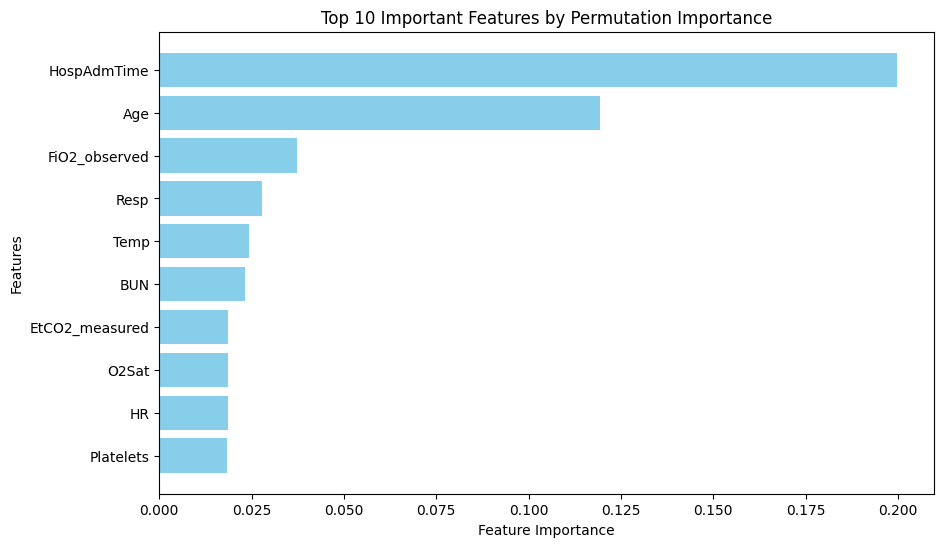

In [46]:
# Plot the results
top_feature_names = [feature_cols[i] for i in top_indices]
top_importances = feature_importances[top_indices]

# Plotting the feature importance
plt.figure(figsize=(10, 6))
plt.barh(top_feature_names, top_importances, color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top 10 Important Features by Permutation Importance')
plt.gca().invert_yaxis()  # Invert y-axis to display the highest importance at the top
plt.show()


## Compute ALE for a Feature

In [47]:
def compute_ale(model, X, feature_idx, n_bins=20, n_samples=500):
    """Compute ALE values for a specific feature across all timesteps"""
    if len(X) > n_samples:
        sample_indices = np.random.choice(len(X), n_samples, replace=False)
        X_sample = X[sample_indices]
    else:
        X_sample = X
    
    n_timesteps = X.shape[1]
    ale_values_per_timestep = []
    bin_centers_per_timestep = []
    
    for t in range(n_timesteps):
        feature_values = X_sample[:, t, feature_idx]
        percentiles = np.linspace(0, 100, n_bins + 1)
        bin_edges = np.percentile(feature_values, percentiles)
        bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
        
        ale = np.zeros(len(bin_edges) - 1)
        local_effects = []
        
        for i in range(len(bin_edges) - 1):
            lower, upper = bin_edges[i], bin_edges[i + 1]
            
            X_lower = X_sample.copy()
            X_upper = X_sample.copy()
            X_lower[:, t, feature_idx] = lower
            X_upper[:, t, feature_idx] = upper
            
            pred_lower = model.predict(X_lower, verbose=0).flatten()
            pred_upper = model.predict(X_upper, verbose=0).flatten()
            
            local_diff = pred_upper - pred_lower
            local_effects.append(local_diff)
        
        ale = np.mean(np.array(local_effects), axis=1)
        ale = np.cumsum(ale) - np.mean(ale)
        
        ale_values_per_timestep.append(ale)
        bin_centers_per_timestep.append(bin_centers)
    
    return bin_centers_per_timestep, ale_values_per_timestep


## ALE Plotting

In [48]:
def plot_ale_comparison(model, X_class0, X_class1, feature_names, feature_idx, 
                       feature_name, n_bins=15, n_samples=500):
    """Plot side-by-side ALE comparison for a feature"""
    print(f"Computing ALE plots for feature: {feature_name}...")
    
    # Compute ALE for both classes
    bins0, ale0 = compute_ale(model, X_class0, feature_idx, n_bins, n_samples)
    bins1, ale1 = compute_ale(model, X_class1, feature_idx, n_bins, n_samples)
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
    fig.suptitle(f'ALE Analysis for {feature_name}', fontsize=16, y=1.05)
    
    # Plot for class 0 (No Sepsis)
    for t in range(len(ale0)):
        ax1.plot(bins0[t], ale0[t], label=f'Timestep {t+1}', alpha=0.7)
    ax1.set_title('Effect on Non-Sepsis Predictions', fontsize=14)
    ax1.set_xlabel(f'Feature Value', fontsize=12)
    ax1.set_ylabel('Effect on Model Output', fontsize=12)
    ax1.axhline(0, color='gray', linestyle='--', linewidth=0.5)
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Plot for class 1 (Sepsis)
    for t in range(len(ale1)):
        ax2.plot(bins1[t], ale1[t], label=f'Timestep {t+1}', alpha=0.7)
    ax2.set_title('Effect on Sepsis Predictions', fontsize=14)
    ax2.set_xlabel(f'Feature Value', fontsize=12)
    ax2.set_ylabel('Effect on Model Output', fontsize=12)
    ax2.axhline(0, color='gray', linestyle='--', linewidth=0.5)
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    print("ALE plot generation completed!")


## Feature Importance Visualization

In [49]:
# Cell 6: Create visualization of feature importance
def plot_feature_importance(feature_names, importances, top_indices):
    """Plot feature importance for top features"""
    top_features = [feature_names[i] for i in top_indices]
    top_importances = [importances[i] for i in top_indices]
    
    plt.figure(figsize=(12, 6))
    bars = plt.barh(range(len(top_features)), top_importances, align='center')
    plt.yticks(range(len(top_features)), top_features)
    plt.xlabel('Importance')
    plt.title('Feature Importance')
    
    # Add value labels on bars
    for i, v in enumerate(top_importances):
        plt.text(v + 0.001, i, f"{v:.4f}", va='center')
    
    plt.tight_layout()
    plt.show()


## Interactive ALE Analysis

In [51]:
import ipywidgets as widgets
from IPython.display import display, clear_output

def create_interactive_ale_analysis(model, X_test, y_test, feature_cols, top_indices):
    """Create interactive widgets for feature analysis"""
    # Prepare class-specific data
    X_class0 = X_test[y_test == 0]
    X_class1 = X_test[y_test == 1]
    
    # Create dropdown for feature selection
    feature_options = [(f"{i+1}. {feature_cols[idx]}") for i, idx in enumerate(top_indices)]
    
    feature_dropdown = widgets.Dropdown(
        options=feature_options,
        value=feature_options[0],
        description='Select Feature:',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='50%')
    )
    
    # Create sliders for bins and sample size
    bins_slider = widgets.IntSlider(
        value=15,
        min=5,
        max=30,
        step=5,
        description='Number of Bins:',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='40%')
    )
    
    samples_slider = widgets.IntSlider(
        value=500,
        min=100,
        max=1000,
        step=100,
        description='Sample Size:',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='40%')
    )
    
    # Create output widget
    out = widgets.Output()
    
    # Function to handle visualization updates
    def update_visualization(change):
        with out:
            clear_output(wait=True)
            
            # Get selected feature index (from dropdown value)
            selected_idx = int(feature_dropdown.value.split('.')[0]) - 1
            feature_idx = top_indices[selected_idx]
            feature_name = feature_cols[feature_idx]
            
            # Generate ALE plots
            plot_ale_comparison(
                model=model,
                X_class0=X_class0,
                X_class1=X_class1,
                feature_names=feature_cols,
                feature_idx=feature_idx,
                feature_name=feature_name,
                n_bins=bins_slider.value,
                n_samples=samples_slider.value
            )
    
    # Button to trigger visualization
    run_button = widgets.Button(
        description='Generate ALE Plots',
        button_style='primary',
        tooltip='Click to generate ALE plots for selected feature',
        layout=widgets.Layout(width='30%')
    )
    
    # Set up observers
    run_button.on_click(update_visualization)
    
    # Display widgets
    display(widgets.VBox([
        widgets.HBox([feature_dropdown]),
        widgets.HBox([bins_slider, samples_slider]),
        run_button,
        out
    ]))


## Launch Interactive ALE Analysis

In [52]:
create_interactive_ale_analysis(
    model=model_cnn,
    X_test=X_test_reshaped,
    y_test=y_test,
    feature_cols=feature_cols,
    top_indices=top_indices
)


## Plot Temporal Feature Contributions

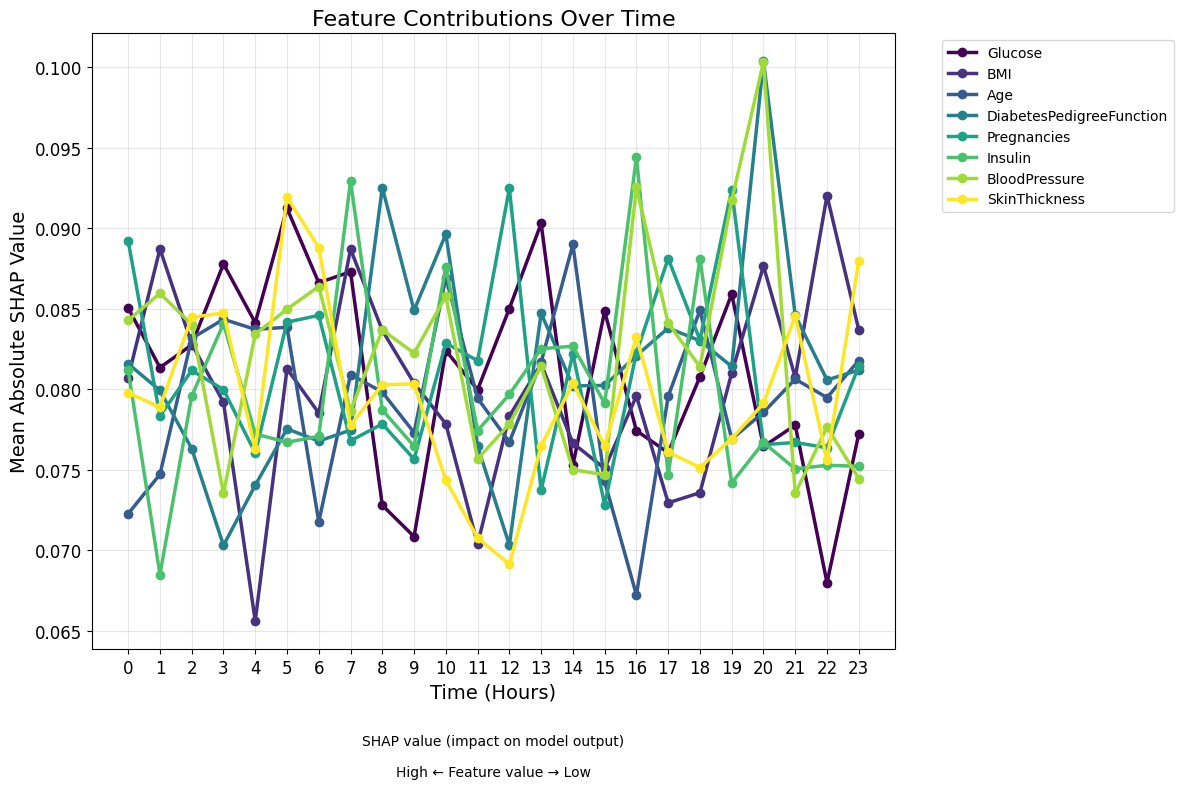

In [53]:
def plot_temporal_feature_contributions(shap_values, feature_names, timesteps):
    """
    Plot SHAP-style feature contributions over time

    Parameters:
    shap_values: 3D array of shape (n_samples, n_timesteps, n_features)
    feature_names: List of feature names
    timesteps: List of timestep labels (e.g., hours)
    """
    # Aggregate absolute SHAP values across samples
    mean_abs_shap = np.mean(np.abs(shap_values), axis=0)
    
    # Create figure
    plt.figure(figsize=(12, 8))
    
    # Create colormap
    colors = plt.cm.viridis(np.linspace(0, 1, len(feature_names)))
    
    # Plot each feature's contribution over time
    for i, feature in enumerate(feature_names):
        plt.plot(timesteps, mean_abs_shap[:, i], 
                label=feature, 
                color=colors[i],
                linewidth=2.5,
                marker='o')
    
    # Customize plot
    plt.title('Feature Contributions Over Time', fontsize=16)
    plt.xlabel('Time (Hours)', fontsize=14)
    plt.ylabel('Mean Absolute SHAP Value', fontsize=14)
    plt.xticks(timesteps, fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Add SHAP value interpretation
    plt.text(0.5, -0.15, 'SHAP value (impact on model output)', 
             ha='center', va='center', transform=plt.gca().transAxes)
    plt.text(0.5, -0.2, 'High ← Feature value → Low', 
             ha='center', va='center', transform=plt.gca().transAxes)
    
    plt.tight_layout()
    plt.show()

# Example usage
n_samples = 100
n_timesteps = 24  # hours
n_features = 8
shap_values = np.random.randn(n_samples, n_timesteps, n_features) * 0.1
feature_names = ['Glucose', 'BMI', 'Age', 'DiabetesPedigreeFunction', 
                 'Pregnancies', 'Insulin', 'BloodPressure', 'SkinThickness']
hours = list(range(n_timesteps))

plot_temporal_feature_contributions(shap_values, feature_names, hours)


## Apply SHAP to Sepsis Model

In [59]:
import shap
import numpy as np

# Apply SHAP to the Sepsis model
def apply_shap_to_sepsis_model(model, X_train, X_test, feature_cols):
    background_samples = min(100, len(X_train))
    background_indices = np.random.choice(len(X_train), background_samples, replace=False)
    X_background = X_train[background_indices]
    instance_to_explain = X_test[0:1]
    
    # Reshape data to 2D (samples x features)
    X_background_reshaped = X_background.reshape(X_background.shape[0], -1)  # Flattening the data
    instance_reshaped = instance_to_explain.reshape(1, -1)  # Flattening the data
    
    # Define model prediction function for SHAP
    def model_predict(x):
        original_shape = (x.shape[0], X_train.shape[1], X_train.shape[2])  # Reshape back to (samples, timesteps, features)
        x_reshaped = x.reshape(original_shape)
        return model.predict(x_reshaped, verbose=0)
    
    # Create SHAP explainer and calculate SHAP values
    explainer = shap.KernelExplainer(model_predict, X_background_reshaped)
    shap_values = explainer.shap_values(instance_reshaped)
    
    # Check if shap_values is a list (it should be in the case of multi-output)
    if isinstance(shap_values, list):
        shap_values = shap_values[0]

    # Reshape SHAP values as needed
    timesteps = X_train.shape[1]
    n_features = X_train.shape[2]
    shap_values_reshaped = shap_values.reshape(1, timesteps, n_features)

    return explainer, shap_values_reshaped


## SHAP Bar Plot

In [ ]:
print(X_train.shape)  # Should print something like (6000, 10, 55)
print(X_test.shape)   # Should print something like (2000, 10, 55)

In [ ]:
print("Feature Columns:", feature_cols)


  0%|          | 0/1 [00:00<?, ?it/s]

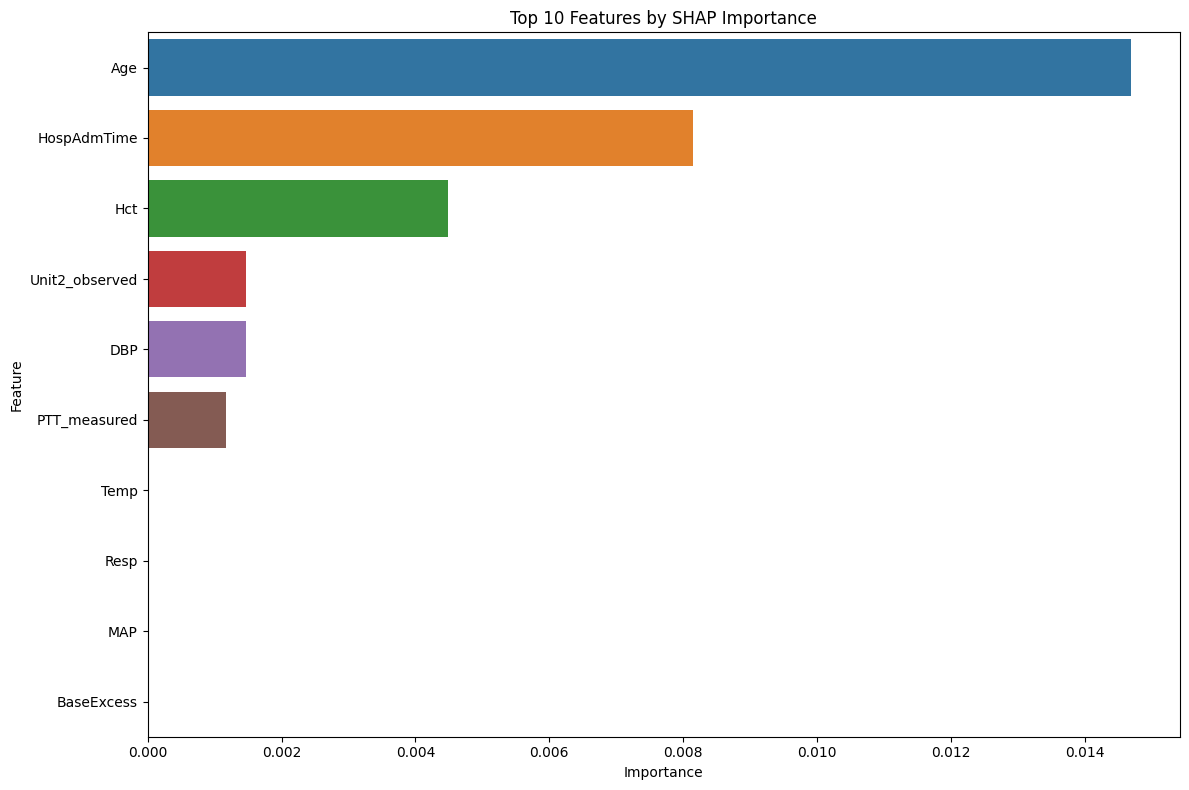

In [60]:
# Function to plot SHAP bar plot for feature importance
def plot_shap_bar(shap_values, feature_cols):
    # Calculate mean absolute SHAP value for each feature
    feature_importance = np.abs(shap_values[0]).mean(axis=0)  # Take the mean across timesteps
    feature_importance_df = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': feature_importance
    }).sort_values('Importance', ascending=False)

    # Plot the top 10 features
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10))
    plt.title('Top 10 Features by SHAP Importance')
    plt.tight_layout()
    plt.show()

# Example usage
explainer, shap_values = apply_shap_to_sepsis_model(model_cnn, X_train, X_test, feature_cols)
plot_shap_bar(shap_values, feature_cols)


In [ ]:
print(shap_values[0])  # Check the SHAP values for all features


In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
from sklearn.inspection import PartialDependenceDisplay

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9657/9657 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9657/9657 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9650/9650 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9650/9650 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9650/9650 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9650/9650 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9650/9650 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9650/9650 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
9650/9650 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
9650/9650 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step


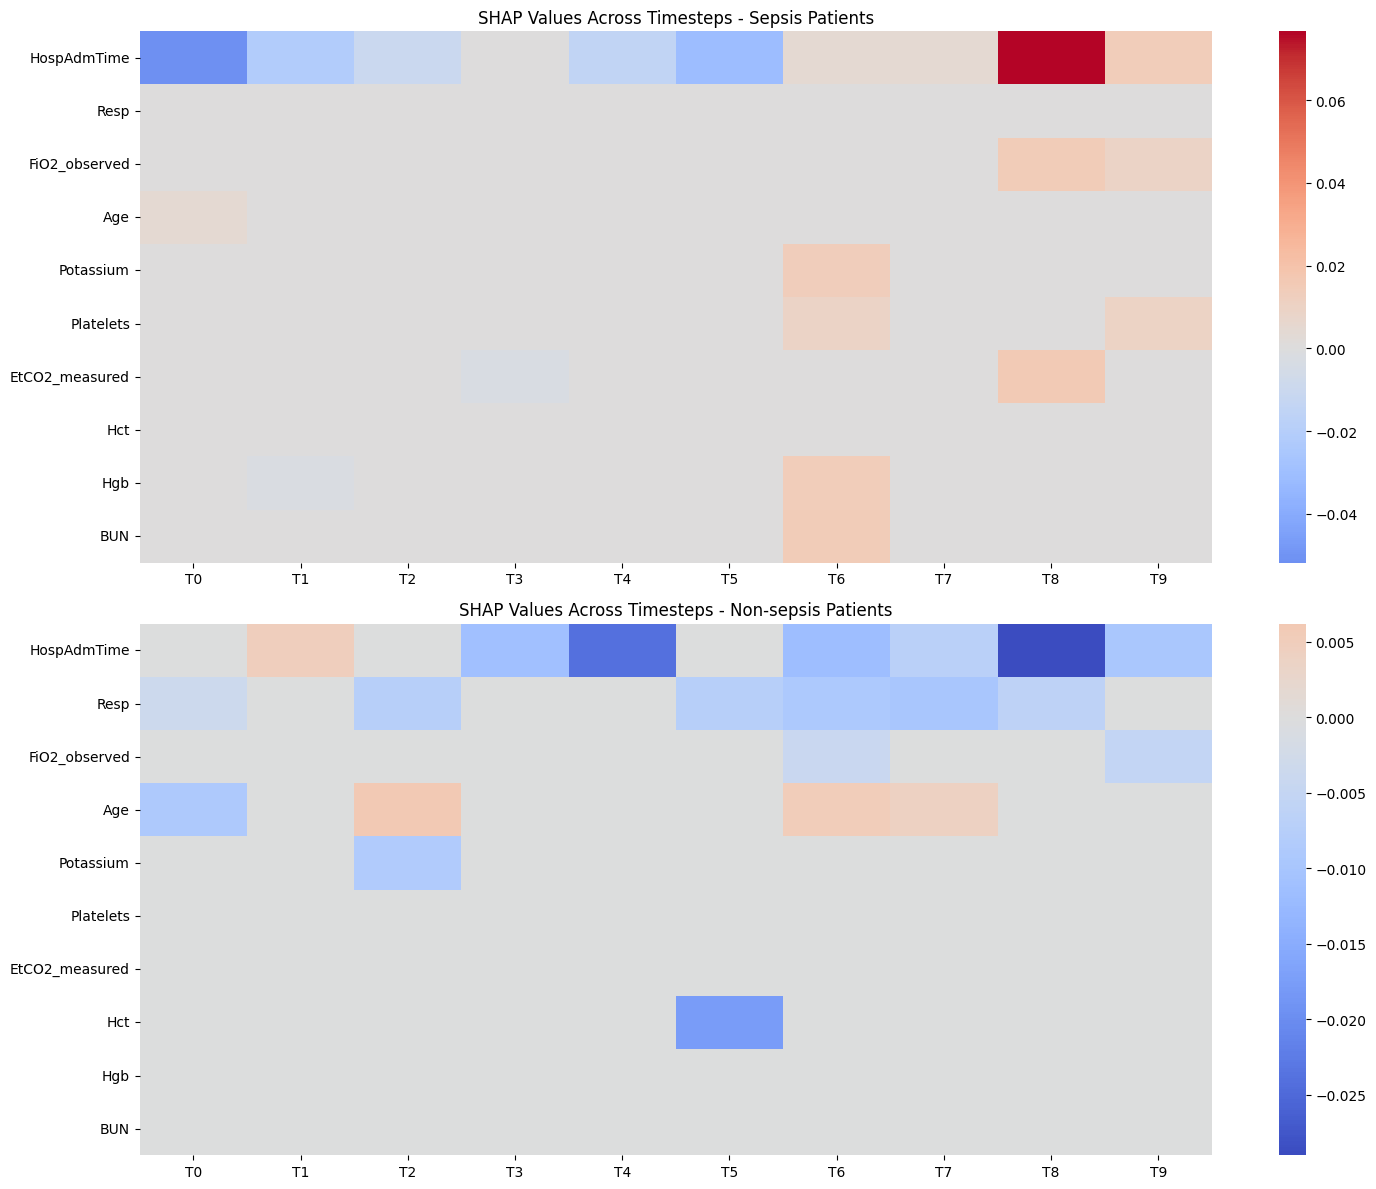

In [61]:
import shap
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def create_shap_heatmap_by_class(model, X_background, X_samples, y_samples, feature_names):
    """
    Create heatmaps separating sepsis vs non-sepsis patients

    Args:
        model: Trained Keras model
        X_background: Background data for SHAP
        X_samples: Sample data
        y_samples: Labels
        feature_names: List of feature names

    Returns:
        Tuple of (top_indices, top_features)
    """
    # Initialize SHAP explainer
    def model_predict(X):
        # Reshape to 2D (samples, timesteps, features)
        X_reshaped = X.reshape(-1, X_background.shape[1], X_background.shape[2])
        return model.predict(X_reshaped)

    # Select a subset of background data for SHAP
    background_subset = X_background[np.random.choice(
        len(X_background),
        min(100, len(X_background)),
        replace=False
    )].reshape(-1, X_background.shape[1] * X_background.shape[2])

    explainer = shap.KernelExplainer(model_predict, background_subset)

    # Separate sepsis from non-sepsis samples
    sepsis_indices = np.where(y_samples == 1)[0][:5]
    non_sepsis_indices = np.where(y_samples == 0)[0][:5]

    X_sepsis = X_samples[sepsis_indices]
    X_non_sepsis = X_samples[non_sepsis_indices]

    # Calculate SHAP values
    def get_shap(X):
        X_flat = X.reshape(X.shape[0], -1)
        sv = explainer.shap_values(X_flat)
        return sv[0] if isinstance(sv, list) else sv

    shap_sepsis = np.mean([get_shap(np.expand_dims(x, 0)) for x in X_sepsis], axis=0)
    shap_non_sepsis = np.mean([get_shap(np.expand_dims(x, 0)) for x in X_non_sepsis], axis=0)

    # Reshape the SHAP values for visualization
    shap_sepsis = shap_sepsis.reshape(X_sepsis[0].shape)
    shap_non_sepsis = shap_non_sepsis.reshape(X_non_sepsis[0].shape)

    # Calculate the feature differences between Sepsis and Non-Sepsis patients
    mean_abs_diff = np.mean(np.abs(shap_sepsis - shap_non_sepsis), axis=0)
    top_indices = np.argsort(mean_abs_diff)[::-1][:10]  # Select top 10 features
    top_features = [feature_names[i] for i in top_indices]

    # Create heatmaps for SHAP values across timesteps
    fig, axes = plt.subplots(2, 1, figsize=(15, 12))

    # Sepsis heatmap
    sns.heatmap(
        shap_sepsis[:, top_indices].T,
        cmap='coolwarm',
        center=0,
        annot=False,
        yticklabels=top_features,
        xticklabels=[f'T{i}' for i in range(X_background.shape[1])],
        ax=axes[0]
    )
    axes[0].set_title('SHAP Values Across Timesteps - Sepsis Patients')

    # Non-sepsis heatmap
    sns.heatmap(
        shap_non_sepsis[:, top_indices].T,
        cmap='coolwarm',
        center=0,
        annot=False,
        yticklabels=top_features,
        xticklabels=[f'T{i}' for i in range(X_background.shape[1])],
        ax=axes[1]
    )
    axes[1].set_title('SHAP Values Across Timesteps - Non-sepsis Patients')

    plt.tight_layout()
    plt.show()

    return top_indices, top_features

# Example usage:
top_indices, top_features = create_shap_heatmap_by_class(model_cnn, X_train[:100], X_test, y_test, feature_cols)


719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
ROC-AUC Score for 1D CNN: 0.8583904625


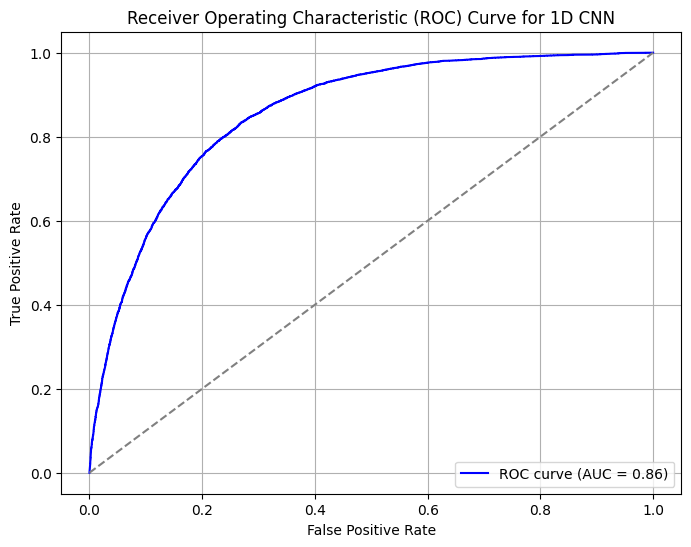

In [66]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Get model predictions (probabilities)
y_pred_prob_cnn = model_cnn.predict(X_test)  # 1D CNN model output is probabilities

# Calculate ROC-AUC score
roc_auc_cnn = roc_auc_score(y_test, y_pred_prob_cnn)

print(f"ROC-AUC Score for 1D CNN: {roc_auc_cnn}")

# Calculate ROC curve
fpr_cnn, tpr_cnn, thresholds_cnn = roc_curve(y_test, y_pred_prob_cnn)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_cnn, tpr_cnn, color='blue', label=f'ROC curve (AUC = {roc_auc_cnn:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for 1D CNN')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [67]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Step 1: Predict on test data
y_pred_cnn = (model_cnn.predict(X_test) > 0.5).astype(int)

# Step 2: Get the classification report (optional, but for extracting F1 scores)
report_cnn = classification_report(y_test, y_pred_cnn, target_names=["Non-Sepsis", "Sepsis"], output_dict=True)

# Step 3: Get confusion matrix
cm_cnn = confusion_matrix(y_test, y_pred_cnn)
TN_cnn, FP_cnn, FN_cnn, TP_cnn = cm_cnn.ravel()

# Step 4: Calculate Utility Score
alpha_cnn = 2  # Example weight for FN (higher weight on FN since sepsis cases are critical)
beta_cnn = 1   # Example weight for FP

utility_score_cnn = TP_cnn / (TP_cnn + alpha_cnn * FN_cnn + beta_cnn * FP_cnn)

# Step 5: Display Utility Score only
print(f"Utility Score for 1D CNN: {utility_score_cnn:.4f}")


719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Utility Score for 1D CNN: 0.4782
